In [1]:
# Import Libraries
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, keras_tuner as kt, tensorflow as tf
import os, datetime, progressbar, copy
import tensorflow_probability as tfp

tfd = tfp.distributions

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint#, TensorBoard                                                                      
from keras import backend as K
from livelossplot import PlotLossesKeras

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hypermodel import HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
#from tensorboard.plugins.hparams import api as hp                                                                             
#from keras.utils.generic_utils import get_custom_objects                                                                      

import gc
gc.enable()

hp = HyperParameters()
plotlosses = PlotLossesKeras()

In [2]:
pwd

'/Users/tashaleebillings/Desktop/Tasha_Desktop/ThesisResearch/ML/notebooks'

In [3]:
ls -lrt

total 54589184
-rw-r--r--@  1 tashaleebillings  staff      9733350 Jul  7  2020 filter_vis.ipynb
-rw-r--r--   1 tashaleebillings  staff      3077544 Jul  7  2020 Meeting_03_13_2020.ipynb
drwxr-xr-x@  6 tashaleebillings  staff          192 Jul 11  2020 learning/
-rw-r--r--   1 tashaleebillings  staff     82000524 Sep 23 15:54 toy_models_32x32.npz
-rw-r--r--   1 tashaleebillings  staff        24387 Oct 11 16:22 Bayesian_Toy_Model.ipynb
-rw-r--r--   1 tashaleebillings  staff      2623533 Oct 13 08:41 Bayesian_Toy_Model_1.ipynb
drwxr-xr-x@ 29 tashaleebillings  staff          928 Oct 25 16:55 toy_model_tuner/
-rw-r--r--   1 tashaleebillings  staff       157960 Oct 25 16:56 hyperParam_weights_5.h5
-rw-r--r--   1 tashaleebillings  staff       495008 Oct 25 16:56 hyperParam_model_5.h5
-rw-r--r--   1 tashaleebillings  staff       468208 Oct 25 16:56 hyperParam_weights_6.h5
-rw-r--r--   1 tashaleebillings  staff      1425984 Oct 25 16:56 hyperParam_model_6.h5
-rw-r--r--   1 tashaleebillings  sta

In [4]:
toy_model = np.load('toy_models_32x32.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']
outputdir = "./"
project_name='toy_model_tuner_32_section2_noise'
idx = "32"

HP_EPOCH = 30
HP_BATCH_SIZE = 5
factor = 100
num_models = 25

In [5]:
X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

NUM_TRAIN_EXAMPLES = len(training_data)
kl_divergence_function = (
lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES,dtype=tf.float32)
)

training (8000, 32, 32, 1)
validation (2000, 32, 32, 1)


In [6]:
var_nomode = [.01, .001, .0001]
var_mode = [0.01, 0.001, 1e-4 ]

"""
Parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
"""

def noisy(noise_typ,image, var):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)
        noisy = image + image * gauss
        return noisy

variances = var_nomode

noisy_X_train = []
noisy_X_test = []

for variance in variances:
    print("Variance ",variance)
    # copying over data
    print("Reading in data ...")
    x_test = copy.deepcopy(X_test)
    x_train = copy.deepcopy(X_train)

    for i in range(x_test.shape[0]):
        # replace each image with noisy data
        x_test[i] = noisy(noise_typ="gauss",image= x_test[i], var=variance)

    for i in range(x_train.shape[0]):
        # replace each image with noisy data
        x_train[i] = noisy(noise_typ="gauss",image= x_train[i], var=variance)

    # append to list
    print("Append data ...")
    noisy_X_train.append(x_train)
    noisy_X_test.append(x_test)
           
noisy_X_train = np.array(noisy_X_train)
noisy_X_test = np.array(noisy_X_test)


Variance  0.01
Reading in data ...
Append data ...
Variance  0.001
Reading in data ...
Append data ...
Variance  0.0001
Reading in data ...
Append data ...


In [7]:
noisy_X_train.shape

(3, 8000, 32, 32, 1)

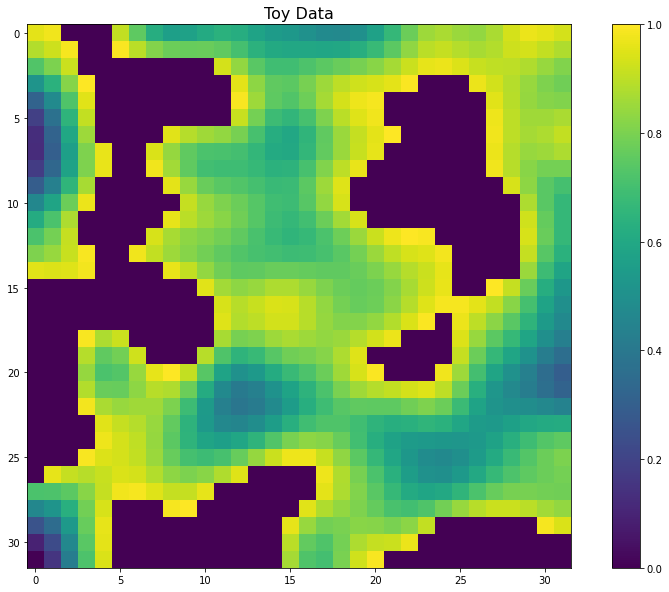

In [8]:
plt.figure(figsize=(15, 10))
plt.imshow(X_train[0,:,:,0])
plt.title("Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

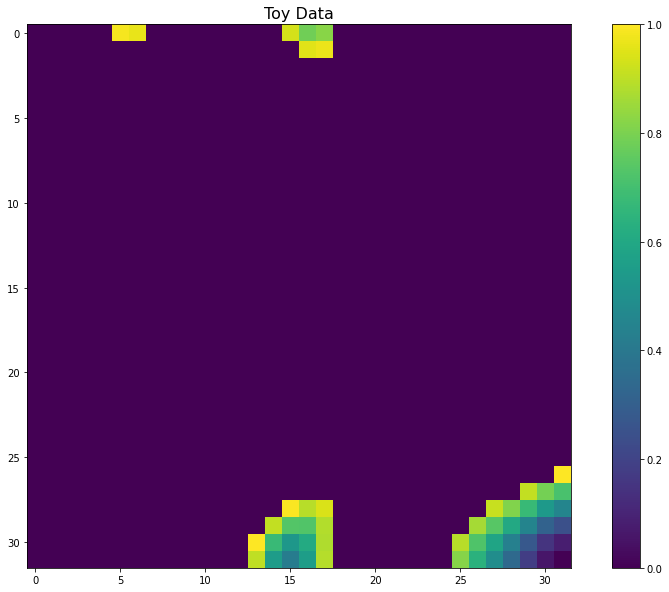

In [9]:
plt.figure(figsize=(15, 10))
plt.imshow(X_train[2,:,:,0])
plt.title("Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

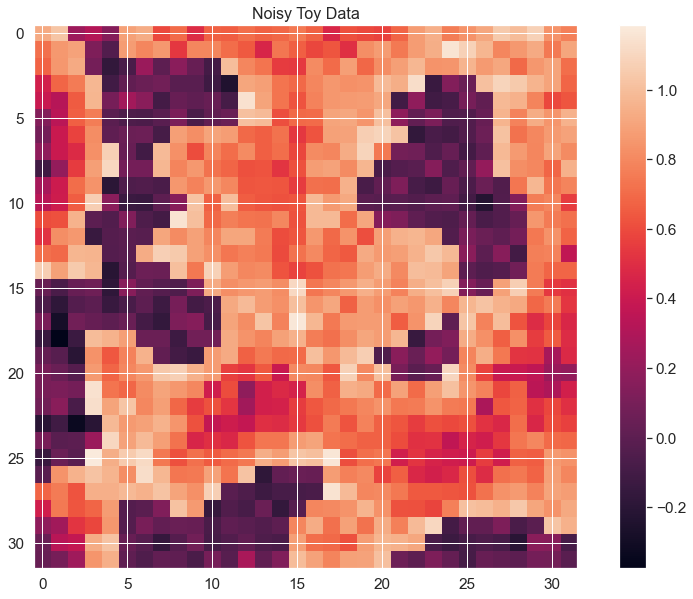

In [39]:
plt.figure(figsize=(15, 10))
plt.imshow(noisy_X_train[0][0,:,:,0])
plt.title("Noisy Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

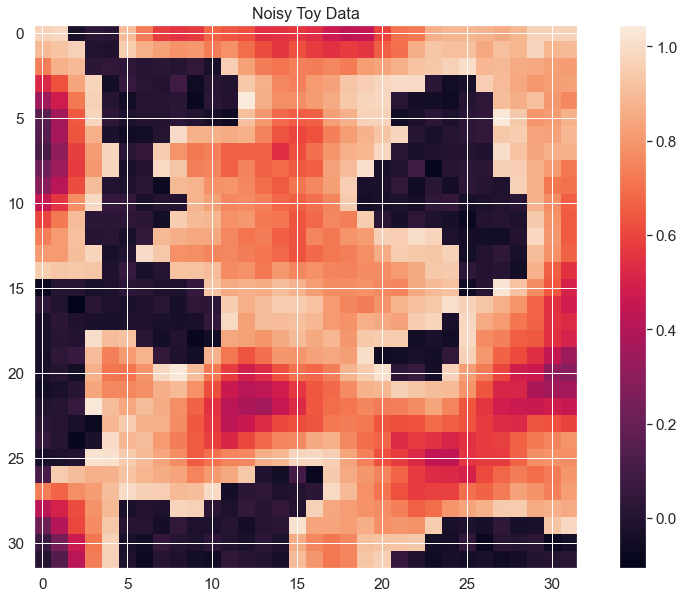

In [37]:
plt.figure(figsize=(15, 10))
plt.imshow(noisy_X_train[1][0,:,:,0])
plt.title("Noisy Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

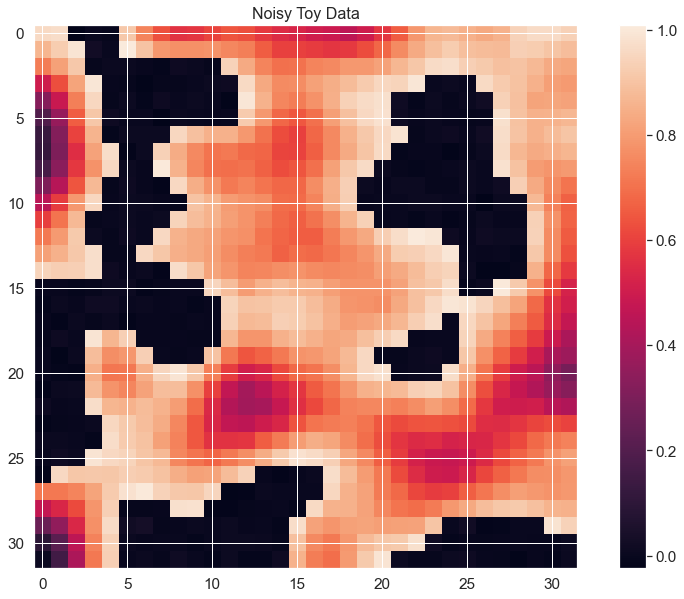

In [38]:
plt.figure(figsize=(15, 10))
plt.imshow(noisy_X_train[2][0,:,:,0])
plt.title("Noisy Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


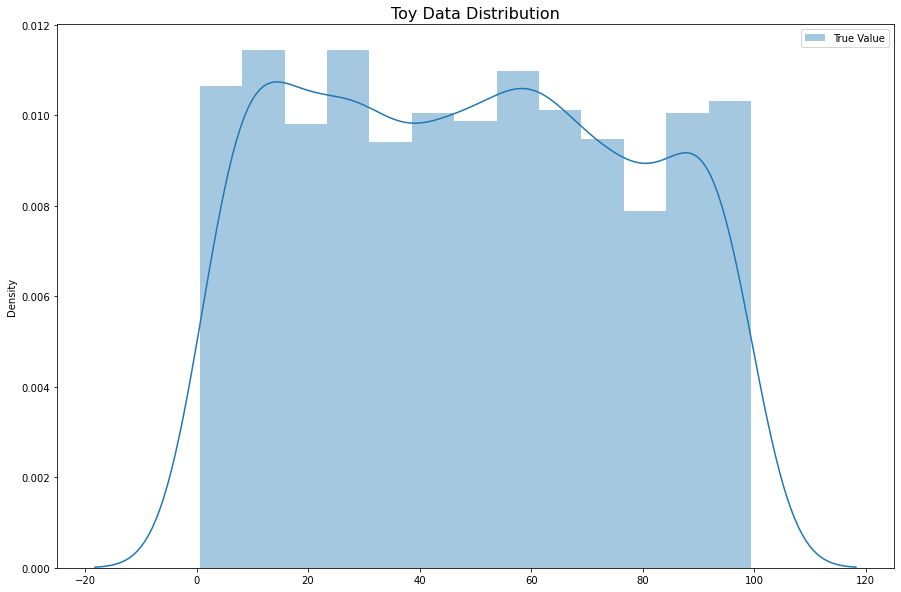

In [13]:
plt.figure(figsize=(15, 10))
sns.distplot(y_test,label="True Value")
plt.title("Toy Data Distribution",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

In [14]:
# Custom Loss Functions                                                                                                               
kl_divergence = tf.keras.losses.KLDivergence()

neg_log_likelihood = lambda y_true, y_pred: -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))

def Mean_Squared_over_true_Error(y_true, y_pred):
    # Create a custom loss function that divides the difference by the true

    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.
    diff_ratio = K.square((y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None))

    loss = K.mean(diff_ratio, axis=-1)

    # Return a tensor
    return loss

def elbo(y_true, y_pred):
    kl_weight = 1
    neg_log_likelihood = -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))
    kl_divergence = tf.keras.losses.KLDivergence()

    elbo_loss = -tf.math.reduce_mean(-kl_weight * kl_divergence(y_true, y_pred.mean()) - neg_log_likelihood)
    # Return a tensor
    return elbo_loss

def mean_fractional_error(y_true, y_pred):
    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.
    diff_ratio = (y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None)
    loss = K.mean(diff_ratio, axis=-1)
    
    return loss

keras.utils.get_custom_objects().update({'Mean_Squared_over_true_Error':Mean_Squared_over_true_Error,
                                        'neg_log_likelihood': neg_log_likelihood, 'kl_divergence':kl_divergence,
                                        'elbo':elbo})
    

In [15]:
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)

    # mean of x and y vector
    m_x, m_y = np.mean(x), np.mean(y)

    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x

    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x

    return [b_0, b_1]
    
def plot_regression(x, y, b, labelname):
    # plotting the actual points as scatter plot
    plt.figure(figsize=(15,15))
    plt.title(labelname)
    plt.scatter(x,y, s=6, lw=0, alpha=0.9)

    # predicted response vector
    y_pred = b[0] + b[1]*x

    # plotting the regression line
    plt.plot(x, y_pred, 'k--',lw=5,alpha=1.0)
    
    # Plot trendline
    xx = np.linspace(0.95*np.min(x), 1.05*np.max(x), 1000)
    plt.plot(xx, xx, 'r--',lw=5,alpha=1.0)

    # putting labels
    plt.xlabel('True Optical Depth', size = 16)
    plt.ylabel('Prediction', size=16)
    
    #plt.legend(markerscale=2.5)
    plt.tight_layout()

    # Save plot
    #plt.savefig(outputdir+"residual_{}.png".format(str(fold)))
    #plt.clf()

# Plot Slope and y-intercept distribution
def statistics_plot_coef(coefficient):
    coefficients = np.array(coefficient,dtype=np.float64)
    plt.plot(np.arange(1,11),coefficients,'o')
    mean_value = np.mean(coefficients,axis=0)
    mean = np.zeros_like(coefficients)
    mean[:,0]=mean_value[0]
    mean[:,1]=mean_value[1]
    plt.plot(np.arange(1,11),mean,'k--',lw=1,markersize=4)
    plt.text(5.0, 0.2, r'$\mu$ vector [b_0 , b_1]: '+str(mean_value),
            {'color': 'blue', 'fontsize': 10, 'ha': 'center', 'va': 'center',
            'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
            
    plt.xlabel("Fold Number")
    plt.ylabel("Distance from Mean")
    #plt.savefig(outputdir+"bestmodel_residual_of_mean.png")
    plt.clf()

# Plot values of the deviation from the mean
def statistics_plot_dev(coefficient):
    coefficients = np.array(coefficient,dtype=np.float64)

    plt.figure(figsize=(13,8))
    plt.plot(np.arange(1,11),coefficients,'o')
    mean_value = np.mean(coefficients,axis=0)
    mean = np.zeros_like(coefficients)
    mean[:,0]=mean_value[0]
    mean[:,1]=mean_value[1]
    plt.plot(np.arange(1,11),mean,'k--',lw=1,markersize=4)
    plt.text(5.0, 0.2, r'$\mu$ vector [b_0 , b_1]: '+str(mean_value),
            {'color': 'blue', 'fontsize': 10, 'ha': 'center', 'va': 'center',
            'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
    for indx, coef in enumerate(coefficients[:,1]):
        diff = (coef-mean_value[1])/2
        plt.vlines(indx+1,coef,mean_value[1],colors='r',linestyles= 'dashed')
        plt.text(indx+1.25, coef-diff, r'%.2f' % diff,
        {'color': 'red', 'fontsize': 10, 'ha': 'center', 'va': 'center'})

    plt.xlabel("Fold Number")
    plt.ylabel("Distance from Mean")
    #plt.savefig(outputdir+"bestmodel_residual_of_mean_dev.png")
    plt.clf()

def main(x, y, labelname):
    # Read in observations
    #x = read_results(filename)[0]
    #y = read_results(filename)[1]

    # estimating coefficients
    b = estimate_coef(x, y)
    coefficients.append(b)
    print("Estimated coefficients:\nb_0 = {} \
        \nb_1 = {}".format(b[0], b[1]))
        
    # write the coefficients to some text file
    fp.write(str(b)+"\n")

    # plotting regression line
    plot_regression(x, y, b, labelname)
    return


# Model 1

## Monte Carlo 



### Model 1.1

In [16]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(noisy_X_train[0], y_train, 
             epochs=5,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(noisy_X_test[0], y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))


"""

Trial 4 Complete [00h 01m 12s]
val_loss: 3.5836215019226074

Best val_loss So Far: 0.6725314855575562
Total elapsed time: 00h 04m 40s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./toy_model_tuner_32_section2_noise
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 0.6725314855575562
Trial summary
Hyperparameters:
loss_type: mae
Score: 3.5836215019226074
Trial summary
Hyperparameters:
loss_type: mse
Score: 7.496054172515869
Trial summary
Hyperparameters:
loss_type: mape
Score: 7.923131465911865
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
____________________________________

'\n# Save best hyperperam Model\nprint("saving best hyperparameter model ...")\nbest_model.save(outputdir+"hyperParam_model_256.h5")\n\n# Save best hyperperam Model Weights\nprint("saving best hyperparameter model weights ...")\nbest_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")\n\n\n# Save all other models so that we can see how the model behaves based on complexity\nfor indx in np.arange(len(tuner.get_best_models(num_models=20))):\n    model_ = tuner.get_best_models(num_models=num_models)[indx]\n    # Save Model weights\n    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))\n    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))\n    # Save Model\n    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))\n    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))\n\n\n'

In [17]:
# print best performing model's loss function
tuner.get_best_models(num_models=1)[0].loss

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None


'Mean_Squared_over_true_Error'

In [18]:
# List of losses: the quantity that a model should seek to minimize during training.
tuner.get_best_models(num_models=1)[0].losses

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None


[<tf.Tensor 'conv2d_flipout/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_1/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout/divergence_kernel:0' shape=() dtype=float32>]

In [19]:
tuner.get_best_models(num_models=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
___________________________

In [20]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape', 'Mean_Squared_over_true_Error'], 'ordered': False}


In [21]:
tuner.results_summary()

Results summary
Results in ./toy_model_tuner_32_section2_noise
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 0.6725314855575562
Trial summary
Hyperparameters:
loss_type: mae
Score: 3.5836215019226074
Trial summary
Hyperparameters:
loss_type: mse
Score: 7.496054172515869
Trial summary
Hyperparameters:
loss_type: mape
Score: 7.923131465911865


In [42]:
class custom_loss:

    """
    Parameters
    ----------
    y_true : ndarray
        Input array dataset. Will be converted to float.
    y_pred:
        Input array dataset. Will be converted to float.
    """

    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

    # Custom Loss Functions
    kl_divergence = tf.keras.losses.KLDivergence()

    neg_log_likelihood = lambda y_true, y_pred: -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))

    def Mean_Squared_over_true_Error(y_true, y_pred):
        # Create a custom loss function that divides the difference by the true

        y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.
        diff_ratio = K.square((y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None))

        loss = K.mean(diff_ratio, axis=-1)

        # Return a tensor
        return loss

    def elbo(y_true, y_pred):
        kl_weight = 1
        neg_log_likelihood = -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))
        kl_divergence = tf.keras.losses.KLDivergence()

        elbo_loss = -tf.math.reduce_mean(-kl_weight * kl_divergence(y_true, y_pred.mean()) - neg_log_likelihood)
        # Return a tensor
        return elbo_loss

    def mean_fractional_error(y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.
        diff_ratio = (y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None)
        loss = K.mean(diff_ratio, axis=-1)
        
        return loss

    keras.utils.get_custom_objects().update({'Mean_Squared_over_true_Error':Mean_Squared_over_true_Error,
                                            'neg_log_likelihood': neg_log_likelihood, 'kl_divergence':kl_divergence,
                                            'elbo':elbo})
        



In [45]:
custom_loss.kl_divergence(y_true, y_pred).numpy()

0.45814306

In [ ]:
y_true = [[0, 1], [0, 0]]
y_pred = [[0.6, 0.4], [0.4, 0.6]]
kl_divergence(y_true, y_pred).numpy()

In [22]:
bestmodel=tuner.get_best_models(num_models=1)[0]#.predict(X_test)
pred = []

for i in range(500):
    y_p = bestmodel.predict(noisy_X_test[0]).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    pred.append(y_p)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None


/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

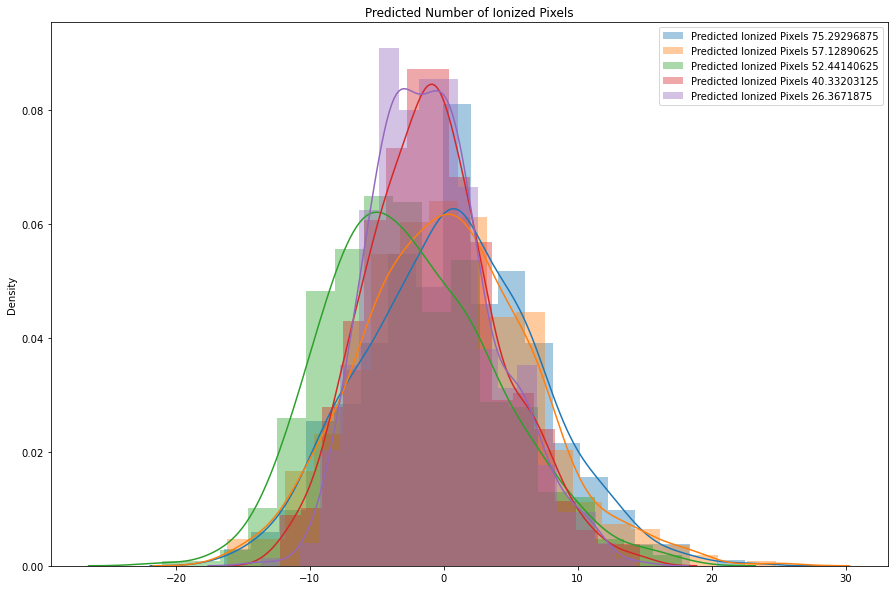

In [23]:
plt.figure(figsize=(15, 10))
plt.title("Predicted Number of Ionized {}".format("Pixels",size = 16 ))

sns.distplot(np.array(pred)[:,0]-y_test[0],label="Predicted Ionized Pixels {}".format(str(y_test[0])))
sns.distplot(np.array(pred)[:,1]-y_test[1],label="Predicted Ionized Pixels {}".format(str(y_test[1])))
sns.distplot(np.array(pred)[:,2]-y_test[2],label="Predicted Ionized Pixels {}".format(str(y_test[2])))
sns.distplot(np.array(pred)[:,3]-y_test[3],label="Predicted Ionized Pixels {}".format(str(y_test[3])))
sns.distplot(np.array(pred)[:,4]-y_test[4],label="Predicted Ionized Pixels {}".format(str(y_test[4])))

#plt.xlim([0, 1.25])
plt.legend(markerscale=2.5)

In [24]:
np.array(pred)[:,0]

array([66.07623 , 75.64302 , 70.26638 , 67.3321  , 81.0606  , 83.44776 ,
       77.065796, 73.95539 , 69.34761 , 65.64854 , 68.47702 , 66.65244 ,
       74.79904 , 69.09195 , 82.522575, 86.45364 , 73.2827  , 85.98574 ,
       73.988396, 63.70125 , 76.28796 , 77.93735 , 75.804115, 79.94153 ,
       78.73685 , 88.40852 , 78.14759 , 71.82902 , 80.16587 , 70.97987 ,
       71.20641 , 67.06676 , 76.498276, 76.69616 , 71.647736, 82.34789 ,
       62.961426, 68.36464 , 81.267784, 81.91916 , 67.65311 , 79.62011 ,
       70.314285, 64.63105 , 80.99407 , 81.51571 , 73.94    , 74.6467  ,
       72.067375, 71.75729 , 69.17371 , 74.64914 , 87.768074, 78.761406,
       73.71295 , 67.997826, 72.12192 , 70.99281 , 72.69554 , 64.68926 ,
       75.27988 , 75.90198 , 79.67647 , 76.268005, 85.92833 , 65.74952 ,
       69.29797 , 74.689926, 71.98385 , 74.38151 , 89.062195, 76.60005 ,
       84.030846, 77.31572 , 71.62696 , 87.20118 , 61.402   , 72.120224,
       69.11759 , 76.43712 , 66.45902 , 60.828537, 

In [25]:
np.array(pred).shape

(500, 2000)

No handles with labels found to put in legend.


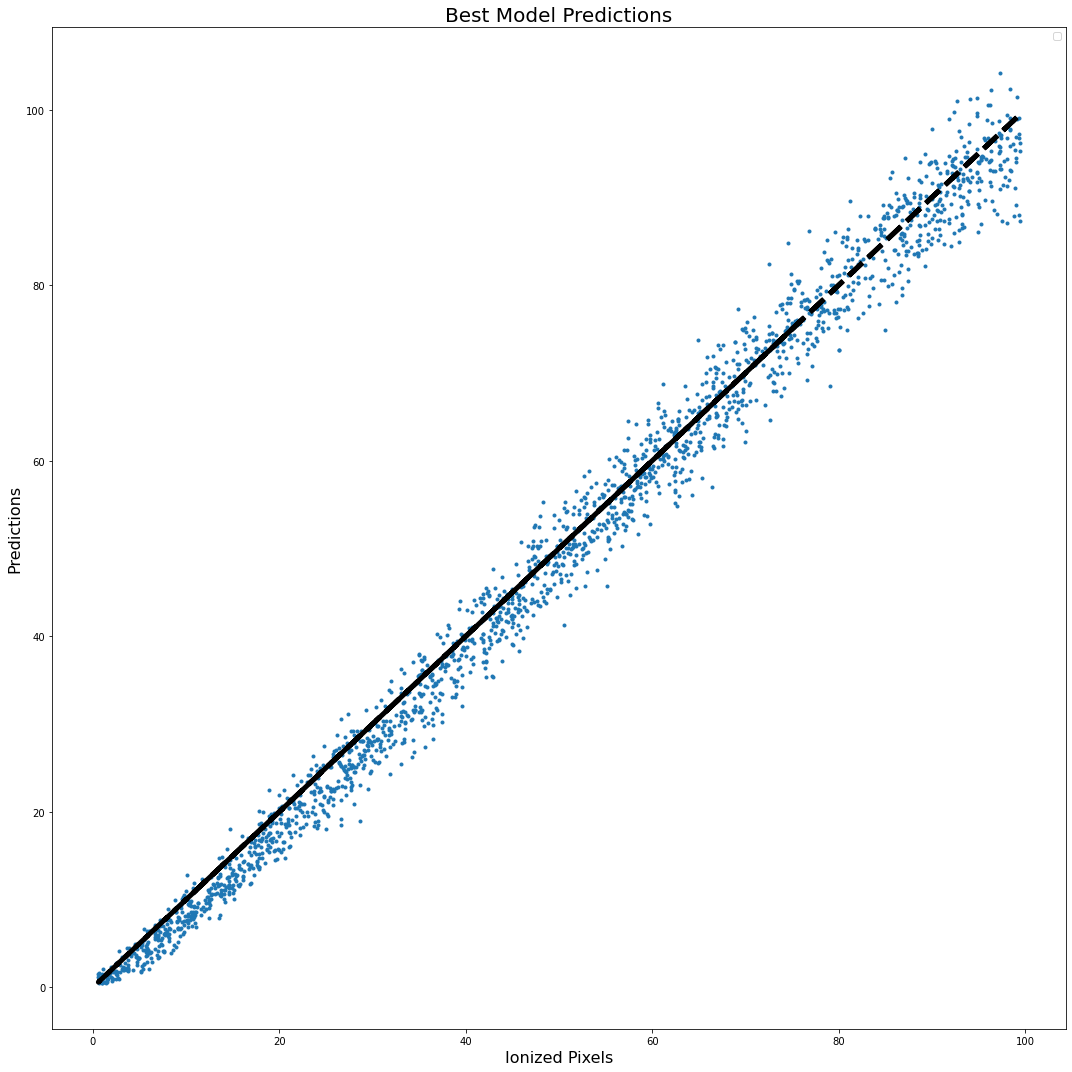

In [26]:
plt.figure(figsize=(15,15))
plt.title("Best Model Predictions", size = 20)

plt.plot(y_test, np.mean(np.array(pred), axis=0), '.')#, label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [27]:
# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(noisy_X_test[0]),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(noisy_X_test[0]).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(noisy_X_test[0].shape)
print(predictions.shape)
print(y_test.shape)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
___________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
___________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
___________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
___________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
___________________________

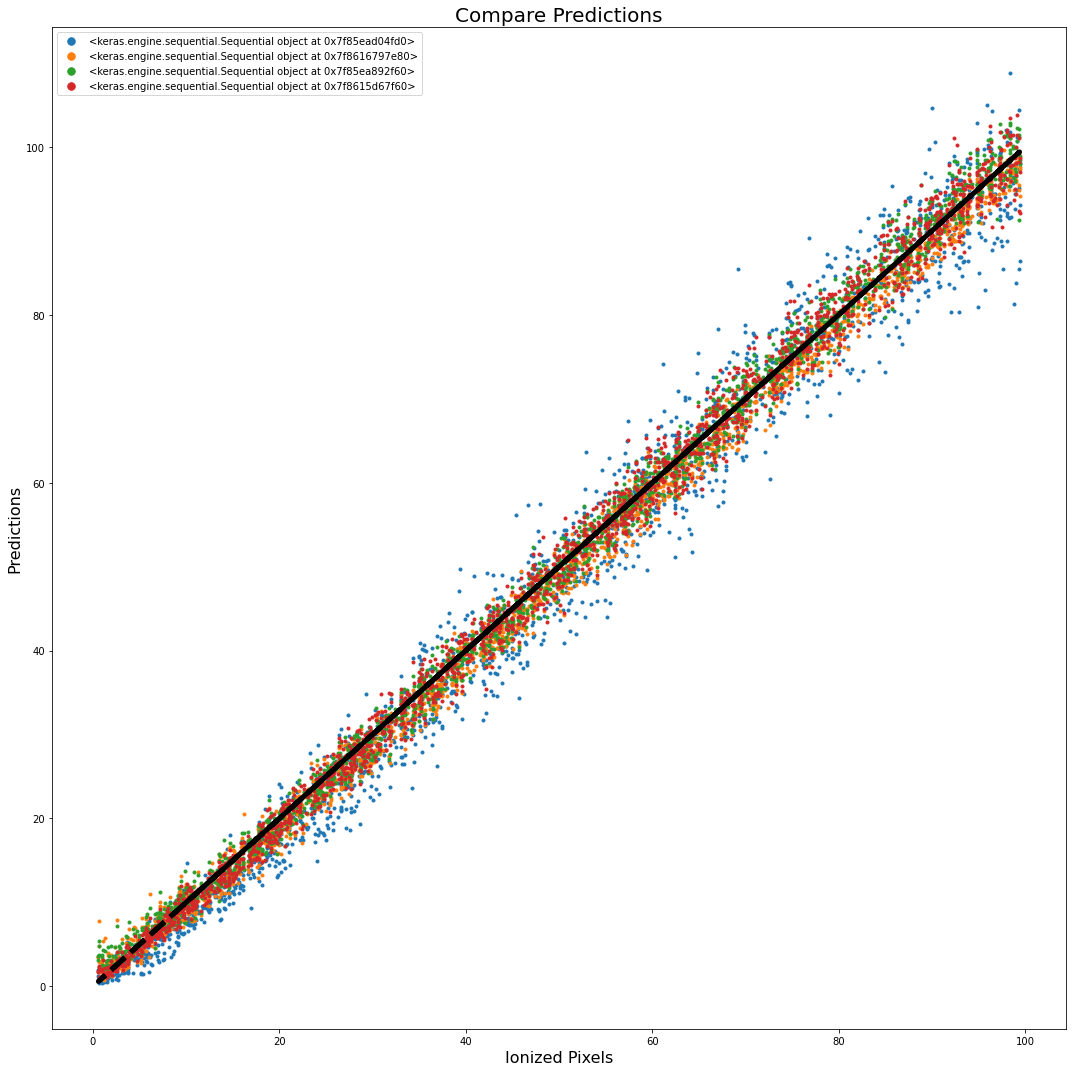

In [28]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,5):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [29]:
predictions.shape

(5, 2000)

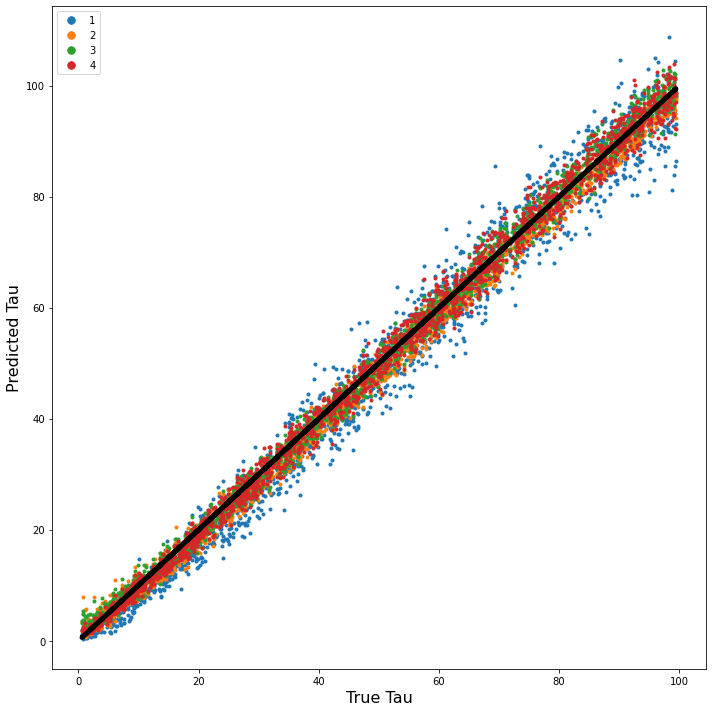

In [30]:
# compare a few of the models
plt.figure(figsize=(10,10))
for l in np.arange(1,5):
    plt.plot(y_test, predictions[l], '.', label = str(l))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


### Empirical Examination of Posterior Distribution

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 12545     
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________
None


/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

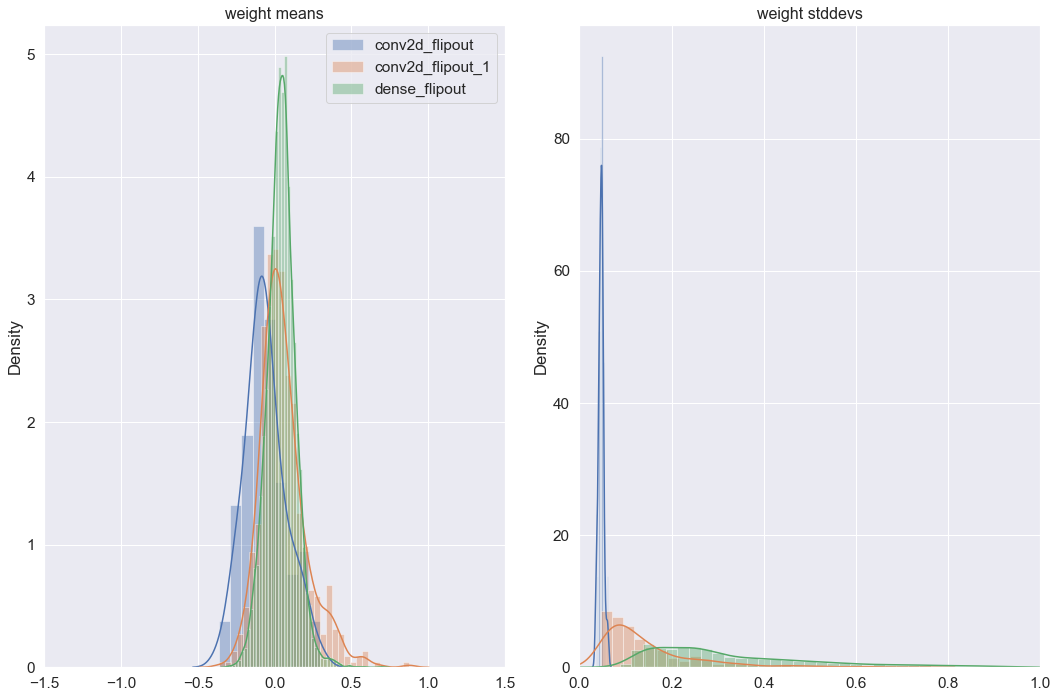

In [31]:
bnn_model = tuner.get_best_models(num_models=1)[0]
sns.set(font_scale=1.4)
def plot_weight_posteriors(names, qm_vals, qs_vals):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
    
names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
qm_vals = [
    layer.kernel_posterior.mean()
    for layer in bnn_model.layers
    if "flipout" in layer.name
]
qs_vals = [
    layer.kernel_posterior.stddev()
    for layer in bnn_model.layers
    if "flipout" in layer.name
]

plot_weight_posteriors(names, qm_vals, qs_vals)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


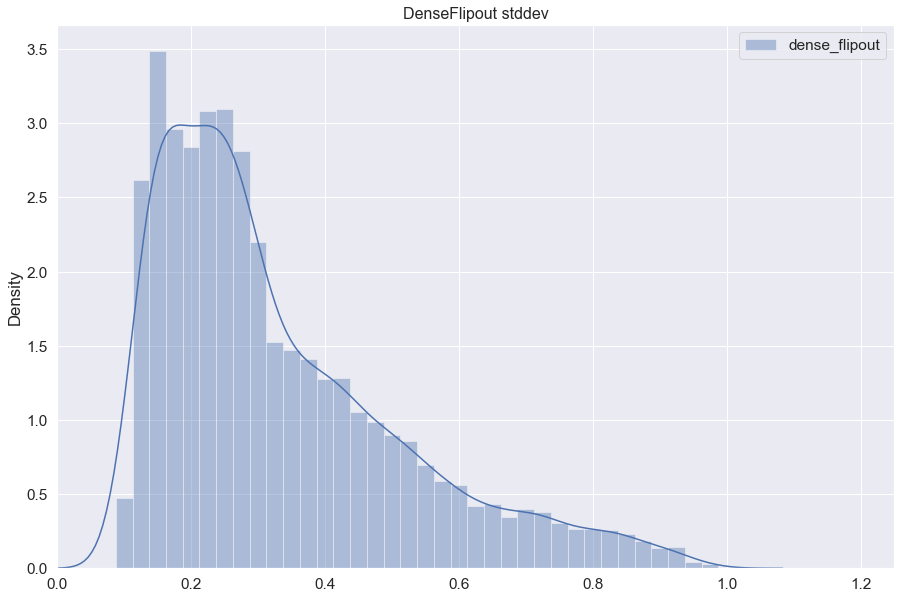

In [32]:
plt.figure(figsize=(15, 10))
sns.distplot(tf.reshape(bnn_model.layers[-1].kernel_posterior.stddev(), shape=[-1]),
             label="{}".format(str(bnn_model.layers[-1].name)))
plt.title("DenseFlipout stddev",size = 16 )
plt.xlim([0, 1.25])
plt.legend()

### Model 1.2

Trial 4 Complete [00h 01m 21s]
val_loss: 2.381382942199707

Best val_loss So Far: 0.37128111720085144
Total elapsed time: 00h 05m 00s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./toy_model_tuner_32_section2_noise
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 0.37128111720085144
Trial summary
Hyperparameters:
loss_type: mae
Score: 2.381382942199707
Trial summary
Hyperparameters:
loss_type: mape
Score: 7.349174976348877
Trial summary
Hyperparameters:
loss_type: mse
Score: 8.475397109985352
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         580       
____________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         580       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 6273      
Total params: 7,005
Trainable params: 7,005
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_____________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         580       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 6273      
Total params: 7,005
Trainable params: 7,005
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_____________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         580       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 6273      
Total params: 7,005
Trainable params: 7,005
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_____________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         580       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 6273      
Total params: 7,005
Trainable params: 7,005
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 8)         152       
_____________________________

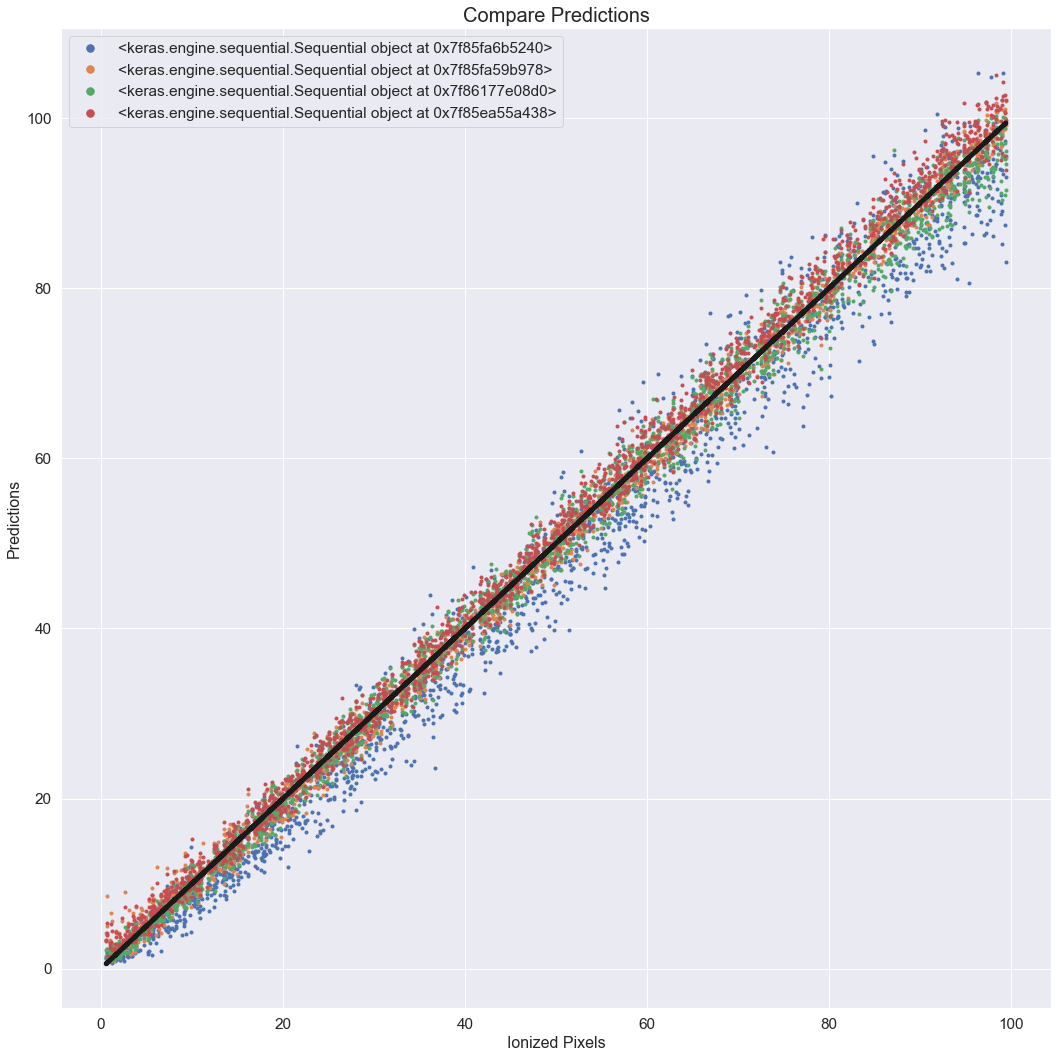

In [33]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(noisy_X_train[0], y_train, 
             epochs=5,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(noisy_X_test[0], y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(noisy_X_test[0]),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(noisy_X_test[0]).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(noisy_X_test[0].shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,5):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


In [ ]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(X_train, y_train, 
             epochs=20,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(X_test, y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(X_test),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,5):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


In [ ]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(X_train, y_train, 
             epochs=5,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(X_test, y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(X_test),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,5):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


In [ ]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(X_train, y_train, 
             epochs=20,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(X_test, y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(X_test),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,5):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


Trial 2 Complete [00h 04m 50s]
val_loss: 1.6834251880645752

Best val_loss So Far: 1.6834251880645752
Total elapsed time: 00h 09m 39s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./toy_model_tuner_32_section2_noise
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: mae
Score: 1.6834251880645752
Trial summary
Hyperparameters:
loss_type: mse
Score: 2.6811022758483887
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         292       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         292       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 6273      
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_____________________________

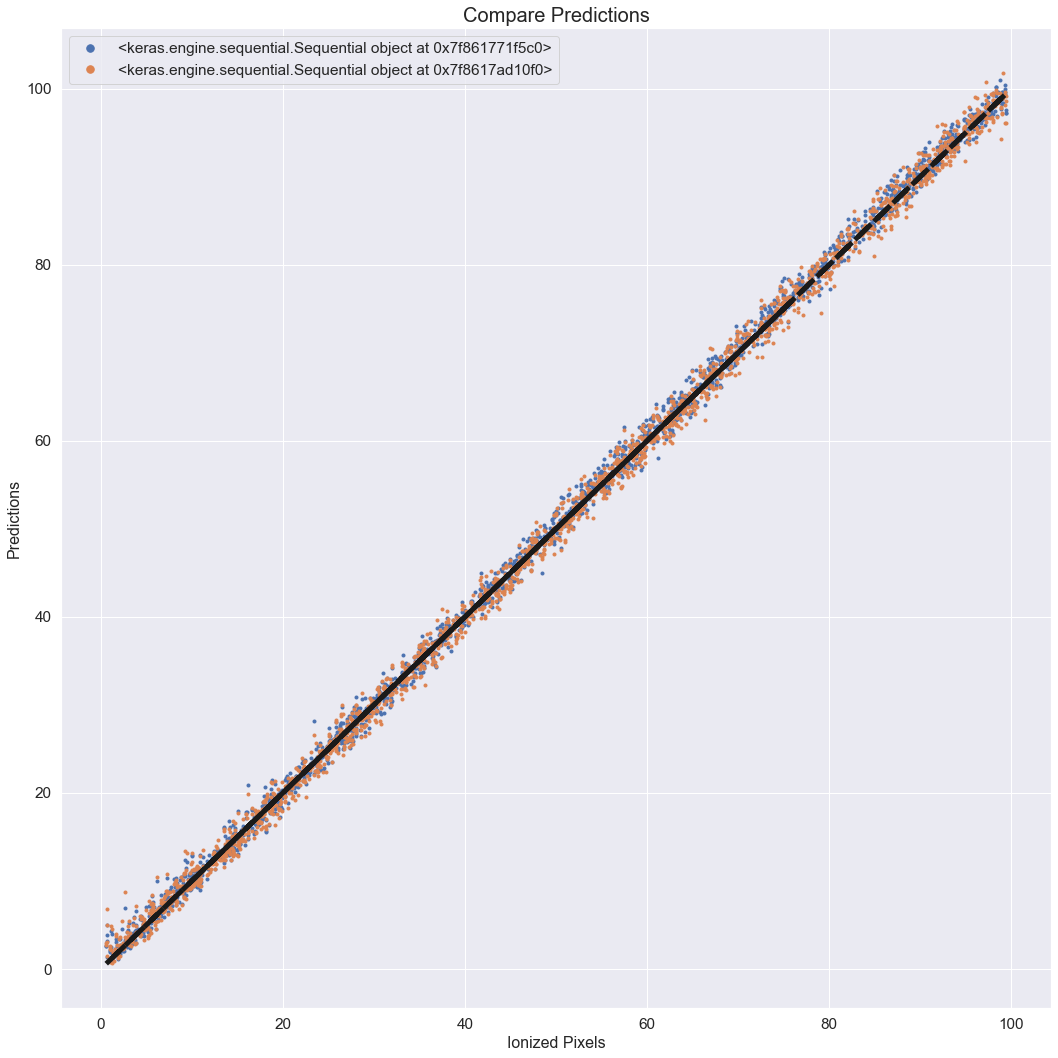

In [34]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(noisy_X_train[0], y_train, 
             epochs=20,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(noisy_X_test[0], y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(noisy_X_test[0]),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(noisy_X_test[0]).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(noisy_X_test[0].shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,3):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


Trial 2 Complete [00h 05m 37s]
val_loss: 1.27642822265625

Best val_loss So Far: 1.27642822265625
Total elapsed time: 00h 11m 07s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./toy_model_tuner_32_section2_noise
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: mae
Score: 1.27642822265625
Trial summary
Hyperparameters:
loss_type: mse
Score: 1.6065930128097534
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         292       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipou

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         292       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 6273      
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_____________________________

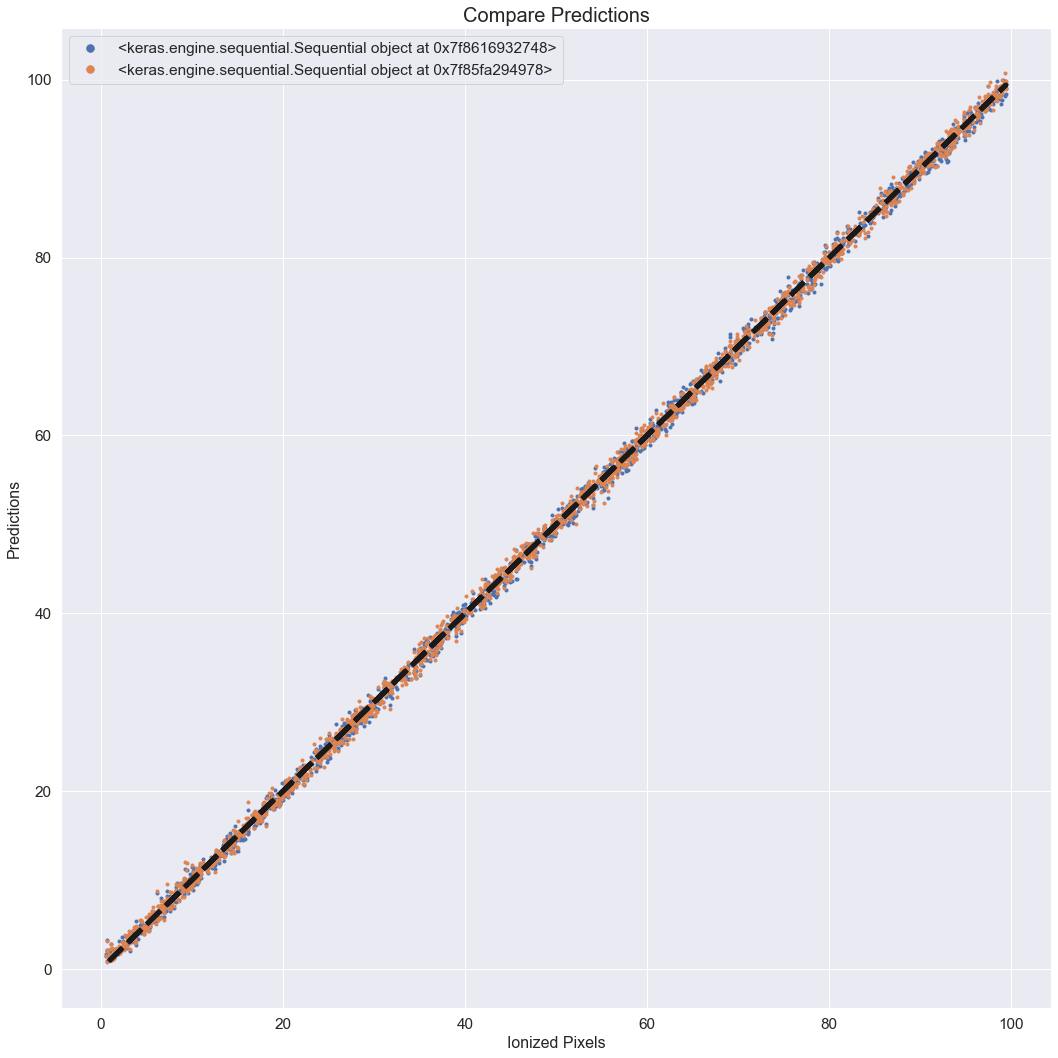

In [35]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(noisy_X_train[1], y_train, 
             epochs=20,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(noisy_X_test[1], y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(noisy_X_test[1]),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(noisy_X_test[1]).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(noisy_X_test[1].shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,3):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


Trial 2 Complete [00h 03m 30s]
val_loss: 1.4276087284088135

Best val_loss So Far: 1.4276087284088135
Total elapsed time: 00h 08m 34s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./toy_model_tuner_32_section2_noise
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: mae
Score: 1.4276087284088135
Trial summary
Hyperparameters:
loss_type: mse
Score: 1.5266278982162476
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         292       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 4)         292       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 6273      
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 4)         76        
_____________________________

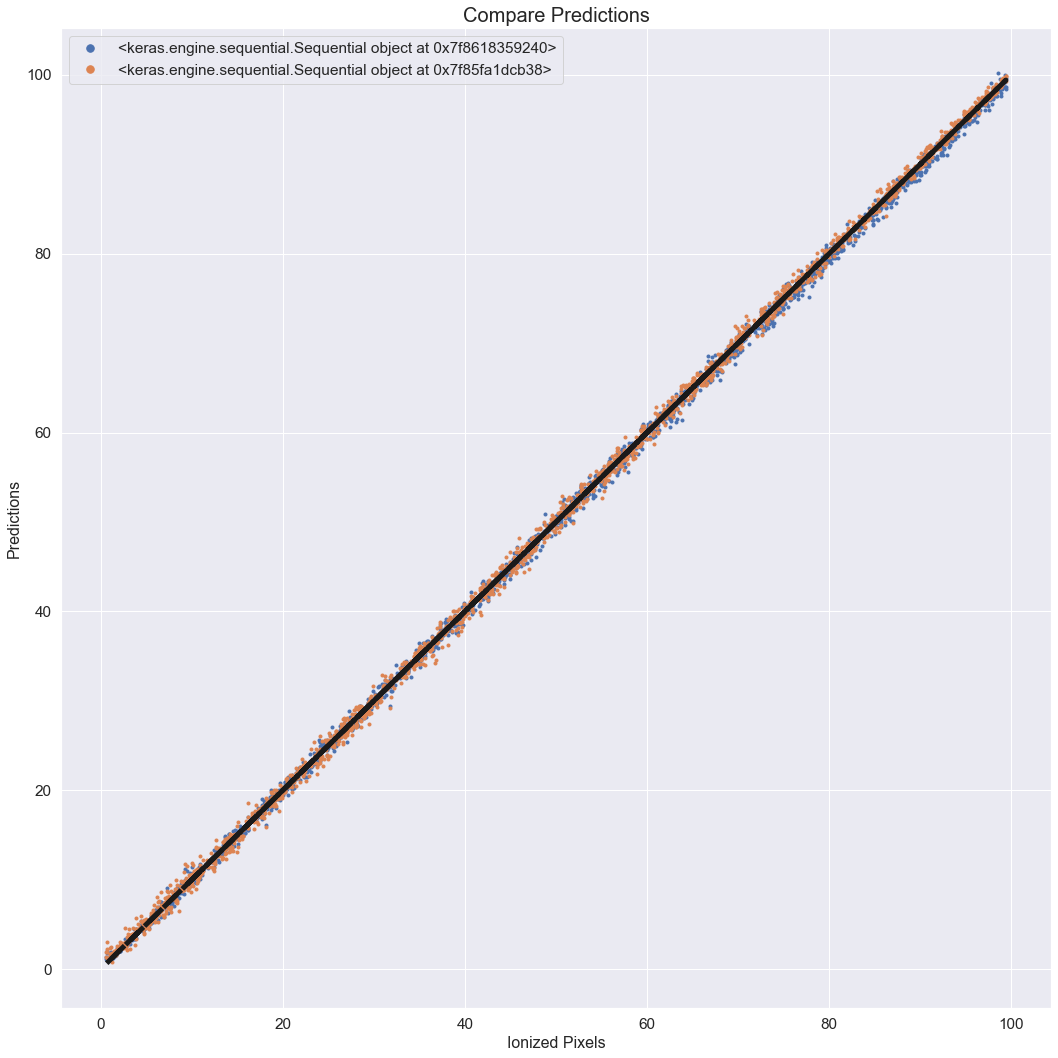

In [36]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(noisy_X_train[2], y_train, 
             epochs=20,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(noisy_X_test[2], y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(noisy_X_test[2]),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(noisy_X_test[2]).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(noisy_X_test[2].shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,3):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


In [ ]:
ls -lrt *.npz

In [ ]:
toy_model = np.load('toy_models_128x128.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']
outputdir = "./"
project_name='toy_model_tuner_128_section1_training_parameter'
idx = "128"

HP_EPOCH = 30
HP_BATCH_SIZE = 5
factor = 100
num_models = 25

X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

NUM_TRAIN_EXAMPLES = len(training_data)
kl_divergence_function = (
lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES,dtype=tf.float32)
)

if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(X_train, y_train, 
             epochs=20,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(X_test, y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(X_test),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,3):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


In [ ]:
toy_model = np.load('toy_models_256x256.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']
outputdir = "./"
project_name='toy_model_tuner_256_section1_training_parameter'
idx = "256"

HP_EPOCH = 30
HP_BATCH_SIZE = 5
factor = 100
num_models = 25

X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

NUM_TRAIN_EXAMPLES = len(training_data)
kl_divergence_function = (
lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES,dtype=tf.float32)
)

if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_og_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(X_train, y_train, 
             epochs=20,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(X_test, y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

"""
# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model_256.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights_256.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_weights_{}_{}.h5".format(str(indx+1),idx))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))
    print("Saving ... "+outputdir+"hyperParam_model_{}_{}.h5".format(str(indx+1),idx))

"""

print(tuner.results_summary())

# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(X_test),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(5):
        y_p = m.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predictions", size = 20)

for l in np.arange(1,3):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


## Learn STD and Mean

In [ ]:
toy_model = np.load('toy_models_256x256.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']
outputdir = "./"
project_name='toy_model_tuner_256_section1_training_parameter'
idx = "256"

HP_EPOCH = 30
HP_BATCH_SIZE = 5
factor = 100
num_models = 25

X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

NUM_TRAIN_EXAMPLES = len(training_data)
kl_divergence_function = (
lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES,dtype=tf.float32)
)

def train_test_og_model():
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           #scale = 1)))
                           scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))
    

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])
    
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = train_test_og_model()



In [ ]:
# make predictions                                                                                                                                                                      
predictions = []
for i in range(500):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)
    

In [ ]:
prediction = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, prediction, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

In [ ]:
plt.figure(figsize=(15, 10))
plt.title("Predicted Number of Ionized {}".format("Pixels",size = 16 ))

sns.distplot(np.array(predictions)[:,0]-y_test[0],label="Predicted Ionized Pixels {}".format(str(y_test[0])))
sns.distplot(np.array(predictions)[:,1]-y_test[1],label="Predicted Ionized Pixels {}".format(str(y_test[1])))
sns.distplot(np.array(predictions)[:,2]-y_test[2],label="Predicted Ionized Pixels {}".format(str(y_test[2])))
sns.distplot(np.array(predictions)[:,3]-y_test[3],label="Predicted Ionized Pixels {}".format(str(y_test[3])))
sns.distplot(np.array(predictions)[:,4]-y_test[4],label="Predicted Ionized Pixels {}".format(str(y_test[4])))

#plt.xlim([0, 1.25])
plt.legend(markerscale=2.5)


### Plot the distribution of the predictions within a certain range.

In [ ]:
np.array(predictions).shape

In [ ]:
np.array(predictions)[: , np.logical_and(y_test < 60, y_test >= 50)]

In [ ]:
np.array(predictions)[: , np.logical_and(y_test < 60, y_test >= 50)].shape

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(np.array(predictions))
plt.legend(markerscale=2.5)

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(np.array(predictions)[: , np.logical_and(y_test < 2, y_test >= 0)])
plt.legend(markerscale=2.5)

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(np.array(predictions)[: , np.logical_and(y_test < 51, y_test >= 49)])
plt.legend(markerscale=2.5)

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(np.array(predictions)[: , np.logical_and(y_test < 100, y_test >= 98)])
plt.legend(markerscale=2.5)

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [ ]:
yhat = model(X_test) # model.predict(X_test)

In [ ]:
# Compare predicted values
plt.figure(figsize=(13,13))
plt.plot(yhat.mean(), np.mean(np.array(predictions), axis=0), 'r o', label = "")
#plt.plot(y_test, yhat.mean(), 'c *', alpha = 0.5, label = "Method 2: Sigma Output")
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("DistributionLambda Mean", size = 16)
plt.ylabel("MC Mean", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [ ]:
# Compare STDs
plt.figure(figsize=(15,15))
plt.plot(yhat.stddev(), np.std(np.array(predictions), axis=0), 'r o', label = "")

plt.xlabel("DistributionLambda STD", size = 16)
plt.ylabel("MC STD", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [ ]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Monte Carlo vs Sigma in output layer", size = 16)

plt.plot(y_test, np.mean(np.array(predictions), axis=0), 'r o', label = "Method 1: Monte Carlo Sample")
plt.plot(y_test, yhat.mean(), 'c *', alpha = 0.5, label = "Method 2: DistributionLambda")
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [ ]:
y_test.shape

In [ ]:
yhat.mean()

In [ ]:
(yhat.mean().numpy()[0::10]-yhat.stddev().numpy()[0::10]).shape

In [ ]:
# Plot Error
plt.figure(figsize=(15,15))
#plt.title("Error bars for the posterior using Monte Carlo vs Sigma in output layer", size = 16)

plt.errorbar(y_test[0::10], np.mean(np.array(predictions), axis=0)[0::10], yerr=np.std(predictions, axis=0)[0::10], marker='.', 
             mfc='red', mec='green', c='green', mew=2.5, ms=20, ls='', label="Method 1: Monte Carlo Sample")
plt.errorbar(y_test[0::10], yhat.mean().numpy()[0::10,0], yerr=yhat.stddev().numpy()[0::10,0], marker='.', 
             mfc='pink', mec='blue', c='blue', mew=2.5, ms=20, ls='', label="Method 2: DistributionLambda")

plt.plot(y_test[0::10],np.mean(np.array(predictions), axis=0)[0::10]+np.std(predictions, axis=0)[0::10], 'r-', alpha=0.5,
         label='mean + 1 stddev'
        )
plt.plot(y_test[0::10],np.mean(np.array(predictions), axis=0)[0::10]-np.std(predictions, axis=0)[0::10], 'r-', alpha=0.5, 
         label='mean - 1 stddev'
        )

plt.plot(y_test[0::10],yhat.mean().numpy()[0::10]+yhat.stddev().numpy()[0::10], 'g-', alpha=0.5, 
         label='mean + 1 stddev'
        )
plt.plot(y_test[0::10],yhat.mean().numpy()[0::10]-yhat.stddev().numpy()[0::10], 'g-', alpha=0.5, 
         label='mean - 1 stddev'
        )

#plt.fill_between(y_test[0::10],  
#                 yhat.mean().numpy()[0::10,0]-yhat.stddev().numpy()[0::10,0], 
#                 yhat.mean().numpy()[0::10,0]+yhat.stddev().numpy()[0::10,0],
#                 color='blue', alpha=0.5,
#                )

plt.plot(y_test,y_test, "k--", linewidth=7)
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predicitons", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [ ]:
# Plot Error

f=plt.figure(figsize=(15,15))

ax = f.add_subplot(111)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("right")

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')

plt.title("Error bars for the posterior using Monte Carlo vs Sigma in output layer", size = 16)

ax.errorbar(y_test[0::10], (np.mean(np.array(predictions), axis=0)-y_test)[0::10], yerr=np.std(predictions, axis=0)[0::10], marker='.', 
             mfc='red', mec='green', c='green', mew=2.5, ms=20, ls='', label="Method 1: Monte Carlo Sample")
ax.errorbar(y_test[0::10], yhat.mean().numpy()[0::10,0]-y_test[0::10], yerr=yhat.stddev().numpy()[0::10,0], marker='.', 
             mfc='pink', mec='blue', c='blue', mew=2.5, ms=20, ls='', label="Method 2: DistributionLambda")

#ax = f.add_subplot(111)
#ax.yaxis.tick_right()
#ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))
#ax.plot(y_test,y_test-y_test, "k--", linewidth=7)
#plt.grid(axis = 'y', color = 'green', linestyle = '--', linewidth = 0.5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictons", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [ ]:
model.weights

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(yhat.stddev(),label="DistributionLambda")
sns.distplot(np.std(np.array(predictions), axis=0), label= "MC")
plt.title("DenseFlipout stddev",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(yhat.mean(),label="DistributionLambda")
sns.distplot(np.mean(np.array(predictions), axis=0), label= "MC")
sns.distplot(y_test, label= "Test Data")
plt.title("DenseFlipout mean",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

In [ ]:
np.arange(1,len(np.array(predictions)))

In [ ]:
coefficients = []

fp = open(outputdir+"bestmodel_estimated_coefficients_1.log", 'w+')
fp.write("b_0, b_1 \n")

if __name__ == "__main__":

    for p in np.arange(len(tuner.get_best_models(num_models=20))):
        main(x=np.array(predictions)[p], y=y_test, labelname=str(tuner.get_best_models(num_models=15)[p-1]))
    fp.close()
    #statistics_plot_coef(coefficient=coefficients)
    #statistics_plot_dev(coefficient=coefficients)

### Empirical Examination of Posterior Distribution

In [ ]:
bnn_model = model#tuner.get_best_models(num_models=1)[0]
sns.set(font_scale=1.4)
def plot_weight_posteriors(names, qm_vals, qs_vals):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
    
names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
qm_vals = [
    layer.kernel_posterior.mean()
    for layer in bnn_model.layers
    if "flipout" in layer.name
]
qs_vals = [
    layer.kernel_posterior.stddev()
    for layer in bnn_model.layers
    if "flipout" in layer.name
]

plot_weight_posteriors(names, qm_vals, qs_vals)

In [ ]:
qs_vals

In [ ]:
tf.reshape(bnn_model.layers[-2].kernel_posterior.stddev(), shape=[-1])

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(tf.reshape(bnn_model.layers[-2].kernel_posterior.stddev(), shape=[-1]),
             label="{}".format(str(bnn_model.layers[-2].name)))
plt.title("DenseFlipout stddev",size = 16 )
plt.xlim([0, 1.25])
plt.legend()

# Model 2

## Monte Carlo 